#### K8s logs loader
This notebook ingests Kubernetres API logs from a folder into a dataframe and plots them by verb count so you can see at a glance if the data range and shape is as expected. After loading, you can export to csv for ingestion into ML or hunting notebooks, or run additional analytics here.

In [53]:
import pandas as pd
import plotly.express as px
import glob
import os
import json

In [3]:
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.expand_frame_repr', False)

In [ ]:
# Define the folder name to ingest native Kubernetes API logs

def process_json_file(file_path):
    records = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                record = json.loads(line.strip())  
                records.append(record)
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line in {file_path}: {e}")
    return pd.DataFrame(records)

def process_all_json_files(root_directory, max_documents):
    
    all_files = [
        os.path.join(dirpath, file)
        for dirpath, _, filenames in os.walk(root_directory)
        for file in filenames if file.endswith('.log')
    ]
    
    all_dfs = []
    total_documents = 0
    
    for file_path in all_files:
        df = process_json_file(file_path)
        if not df.empty:
            all_dfs.append(df)
            total_documents += len(df)
            print(f"Processed {file_path}: {len(df)} rows, Total: {total_documents}")
        else:
            print(f"Skipped {file_path}: No valid data")
        
        
        if total_documents >= max_documents:
            print(f"Reached the maximum document limit: {max_documents}")
            break
    
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        return final_df
    else:
        print("No valid dataframes to concatenate.")
        return pd.DataFrame()  

root_directory = 'kubernetes-audit-log'
k8s_logs = process_all_json_files(root_directory, max_documents=10_000_000)

# optionally print(k8s_logs.head())

print(f"Number of rows: {k8s_logs.shape[0]}")
print(f"Number of columns: {k8s_logs.shape[1]}")

In [110]:
#Timestamp and date fields

k8s_logs['requestReceivedTimestamp'] = pd.to_datetime(k8s_logs['requestReceivedTimestamp'])
k8s_logs['month'] = k8s_logs['requestReceivedTimestamp'].dt.month
k8s_logs['date'] = k8s_logs['requestReceivedTimestamp'].dt.strftime('%y-%m-%d')  

In [112]:
# Prepare to plot by verbs
verb_month = k8s_logs.groupby(['month', 'verb']).size().reset_index(name='count')
verb_date = k8s_logs.groupby(['date', 'verb']).size().reset_index(name='count')

# print(verb_month.head())
# print(verb_date.head())

   month    verb   count
0     10  create    5316
1     10  delete      42
2     10     get  914849
3     10    list  121572
4     10   patch    4706
       date    verb   count
0  24-10-06  create    1832
1  24-10-06  delete      24
2  24-10-06     get  125067
3  24-10-06    list   16862
4  24-10-06   patch    1180


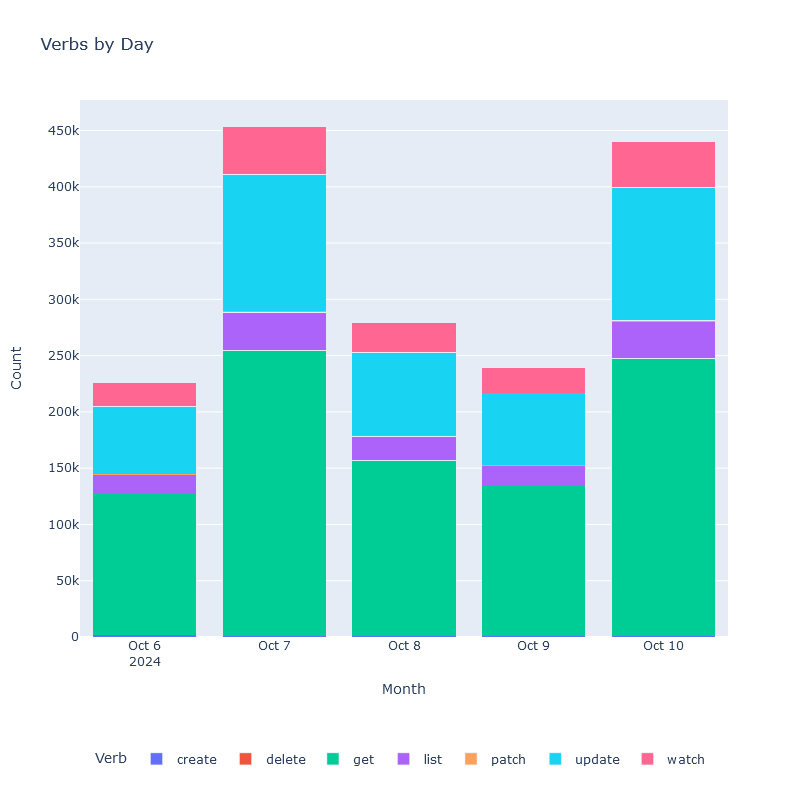

In [114]:
# Plot verbs in a time series histogram
fig = px.bar(
    verb_date, 
    x="date", 
    y="count", 
    color="verb", 
    title="Verbs by Day",
    labels={"date": "Date", "count": "Count", "verb": "Verb"},
    hover_data={"count": True, "verb": True}
)

fig.update_layout(
    barmode='stack',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    legend=dict(title='Verb', orientation="h", x=0.5, xanchor="center", y=-0.2),
    height=800
)

# Yay interactive plot!
fig.show()
